# Regression

In this Notebook we will examine bitcoin prices and see if we can predict the value.

https://www.kaggle.com/mczielinski/bitcoin-historical-data/data

Data under CC BY-SA 4.0 License

https://www.kaggle.com/mczielinski/bitcoin-historical-data


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import ensemble, linear_model, model_selection, preprocessing, svm
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import PredictionError, ResidualsPlot

In [2]:
%%time
# Resampling data from minute interval to day
bit_df = pd.read_csv('../data/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv')
# Convert unix time to datetime
bit_df['date'] = pd.to_datetime(bit_df.Timestamp, unit='s')
# Reset index
bit_df = bit_df.set_index('date')
# Rename columns so easier to code
bit_df = bit_df.rename(columns={'Open':'open', 'High': 'hi', 'Low': 'lo', 
                       'Close': 'close', 'Volume_(BTC)': 'vol_btc',
                       'Volume_(Currency)': 'vol_cur', 
                       'Weighted_Price': 'wp', 'Timestamp': 'ts'})
# Resample based on 'd' - day and aggregate, only use recent samples that aren't missing
bit_df = bit_df.resample('d').agg({'open': 'first', 'hi': 'max', 
    'lo': 'min', 'close': 'last', 'vol_btc': 'sum',
    'vol_cur': 'sum', 'wp': 'mean', 'ts': 'min'}).iloc[-1000:]
# drop last row as it is not complete
bit_df = bit_df.iloc[:-1]

CPU times: user 1.86 s, sys: 430 ms, total: 2.29 s
Wall time: 2.29 s


In [3]:
bit_df

,open,hi,lo,close,vol_btc,vol_cur,wp,ts
date,,,,,,,,
2015-04-15,221.05,224.52,218.09,224.35,9137.584626,2.029524e+06,222.270771,1.429056e+09
2015-04-16,224.35,230.75,223.66,229.45,8636.837666,1.970069e+06,227.779413,1.429142e+09
2015-04-17,229.45,230.08,220.46,223.62,7738.360003,1.741497e+06,224.970863,1.429229e+09
2015-04-18,223.55,224.04,222.18,224.02,5065.649127,1.131269e+06,223.398170,1.429315e+09
2015-04-19,224.02,226.72,223.44,224.03,5279.787312,1.185860e+06,224.667792,1.429402e+09
2015-04-20,224.03,227.45,223.45,225.37,7964.055364,1.793096e+06,225.063422,1.429488e+09
2015-04-21,225.35,235.89,224.01,235.89,10191.153344,2.325789e+06,227.170562,1.429574e+09
2015-04-22,235.89,238.60,232.78,233.98,7661.273982,1.807241e+06,236.029556,1.429661e+09
2015-04-23,233.96,236.54,232.79,235.99,6908.700188,1.622914e+06,234.896309,1.429747e+09


In [4]:
bit_df.head().T

date,2015-04-15 00:00:00,2015-04-16 00:00:00,2015-04-17 00:00:00,2015-04-18 00:00:00,2015-04-19 00:00:00
open,2.210500e+02,2.243500e+02,2.294500e+02,2.235500e+02,2.240200e+02
hi,2.245200e+02,2.307500e+02,2.300800e+02,2.240400e+02,2.267200e+02
lo,2.180900e+02,2.236600e+02,2.204600e+02,2.221800e+02,2.234400e+02
close,2.243500e+02,2.294500e+02,2.236200e+02,2.240200e+02,2.240300e+02
vol_btc,9.137585e+03,8.636838e+03,7.738360e+03,5.065649e+03,5.279787e+03
vol_cur,2.029524e+06,1.970069e+06,1.741497e+06,1.131269e+06,1.185860e+06
wp,2.222708e+02,2.277794e+02,2.249709e+02,2.233982e+02,2.246678e+02
ts,1.429056e+09,1.429142e+09,1.429229e+09,1.429315e+09,1.429402e+09


In [5]:
bit_df.dtypes

open       float64
hi         float64
lo         float64
close      float64
vol_btc    float64
vol_cur    float64
wp         float64
ts         float64
dtype: object

In [6]:
bit_df.describe()

,open,hi,lo,close,vol_btc,vol_cur,wp,ts
count,999.00000,999.000000,999.000000,999.000000,999.000000,9.990000e+02,999.000000,9.990000e+02
mean,1838.11015,1914.705946,1757.861101,1854.054895,10350.019927,3.553735e+07,1842.224578,1.472170e+09
std,3169.30283,3346.396825,2966.458499,3201.173766,9947.604406,1.097365e+08,3165.632076,2.492906e+07
min,211.16000,224.040000,0.060000,211.160000,1525.187302,7.925465e+05,215.969046,1.429056e+09
25%,384.61500,393.500000,371.300000,384.850000,5320.152105,2.297687e+06,384.227045,1.450613e+09
50%,629.79000,639.850000,618.130000,630.830000,7367.614526,3.484114e+06,632.673702,1.472170e+09
75%,1454.14500,1512.965000,1440.095000,1502.495000,11954.181722,1.985804e+07,1471.613323,1.493726e+09
max,19650.02000,19891.990000,19010.000000,19650.010000,165763.024424,1.393385e+09,19537.276941,1.515283e+09


In [7]:
bit_df.describe().T

,count,mean,std,min,25%,50%,75%,max
open,999.0,1.838110e+03,3.169303e+03,2.111600e+02,3.846150e+02,6.297900e+02,1.454145e+03,1.965002e+04
hi,999.0,1.914706e+03,3.346397e+03,2.240400e+02,3.935000e+02,6.398500e+02,1.512965e+03,1.989199e+04
lo,999.0,1.757861e+03,2.966458e+03,6.000000e-02,3.713000e+02,6.181300e+02,1.440095e+03,1.901000e+04
close,999.0,1.854055e+03,3.201174e+03,2.111600e+02,3.848500e+02,6.308300e+02,1.502495e+03,1.965001e+04
vol_btc,999.0,1.035002e+04,9.947604e+03,1.525187e+03,5.320152e+03,7.367615e+03,1.195418e+04,1.657630e+05
vol_cur,999.0,3.553735e+07,1.097365e+08,7.925465e+05,2.297687e+06,3.484114e+06,1.985804e+07,1.393385e+09
wp,999.0,1.842225e+03,3.165632e+03,2.159690e+02,3.842270e+02,6.326737e+02,1.471613e+03,1.953728e+04
ts,999.0,1.472170e+09,2.492906e+07,1.429056e+09,1.450613e+09,1.472170e+09,1.493726e+09,1.515283e+09


In [8]:
bit_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999 entries, 2015-04-15 to 2018-01-07
Freq: D
Data columns (total 8 columns):
open       999 non-null float64
hi         999 non-null float64
lo         999 non-null float64
close      999 non-null float64
vol_btc    999 non-null float64
vol_cur    999 non-null float64
wp         999 non-null float64
ts         999 non-null float64
dtypes: float64(8)
memory usage: 70.2 KB


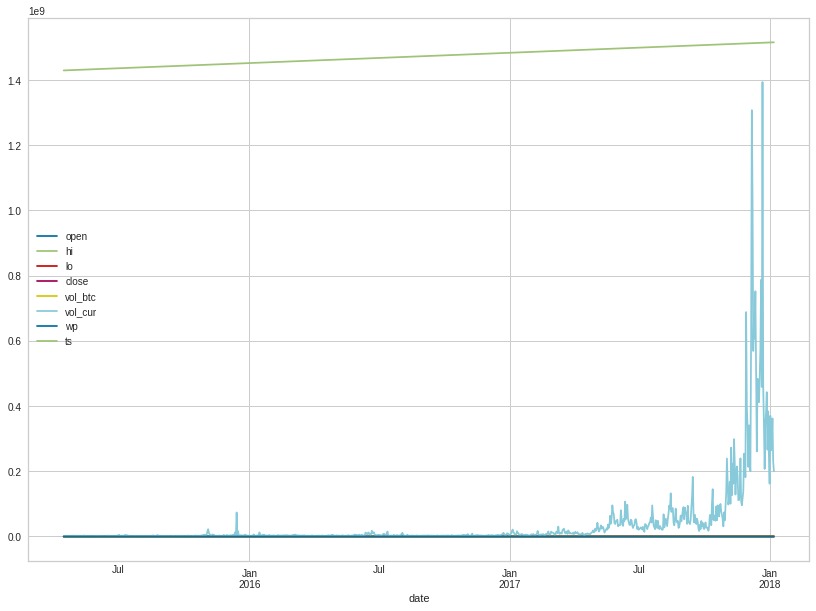

In [9]:
bit_df.plot(figsize=(14,10))

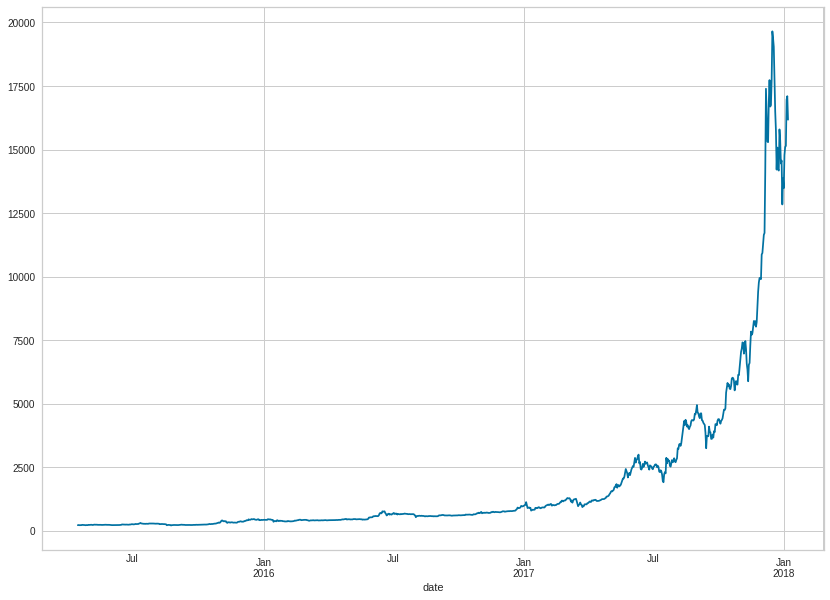

In [10]:
bit_df.close.plot(figsize=(14,10));

## Exercise: Load data
This exercise looks at predicting the size of forest fires based on meteorological data https://archive.ics.uci.edu/ml/datasets/Forest+Fires

The file is in ``../data/forestfires.csv``

* Read the data into a DataFrame
* Examine the types
* Describe the data

Attribute information:

   For more information, read [Cortez and Morais, 2007].

   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform).

In [11]:
df_ff = pd.read_csv('../data/forestfires.csv')

In [12]:
df_ff.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [13]:
df_ff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [14]:
df_ff.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


## Can we predict tomorrow's close based on today's info?
We will use a row of data for input. We will call the input X and the prediction y. This is called "supervised learning" as we will feed in both X and y to train the model.

Let's use a model called Linear Regression. This performs better if we *standardize* the data (0 mean, 1 std).

For 2 dimensions this takes the form of 

\begin{align}
y = m*x + b
\end{align}

M is the slope (or coefficient) and b is the intercept.

Let's see if we can predict the open price from the ts component.

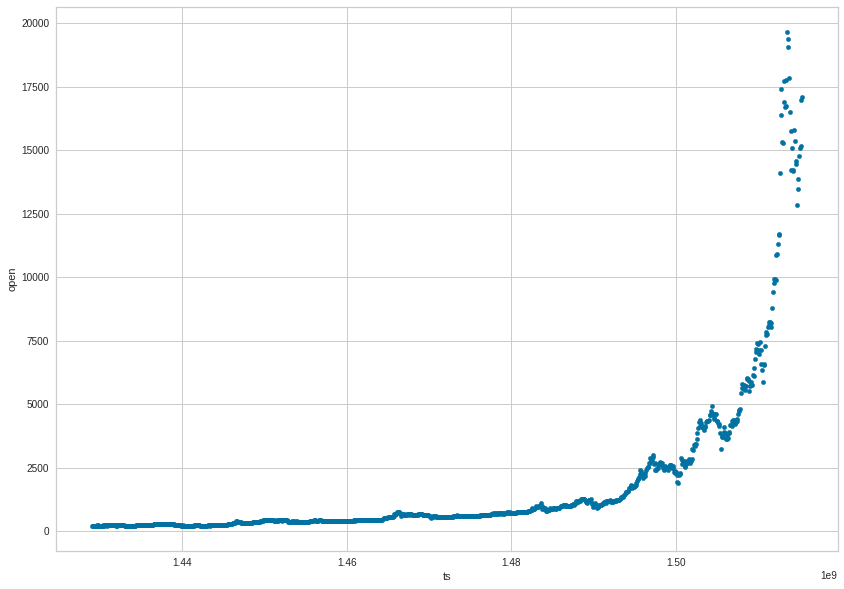

In [15]:
bit_df.plot(kind='scatter', x='ts', y='open', figsize=(14,10))

In [16]:
# Create our input (X) - 'ts' time series column, and our labelled data (y) - target to train our model
X = bit_df[['ts']].iloc[:-1]  # drop last row because we don't know what future is
y = bit_df.close.shift(-1).iloc[:-1]

In [17]:
# Train a model and predict output if it were given X
lr_model = linear_model.LinearRegression()
lr_model.fit(X, y) # train model
pred = lr_model.predict(X) # predict y

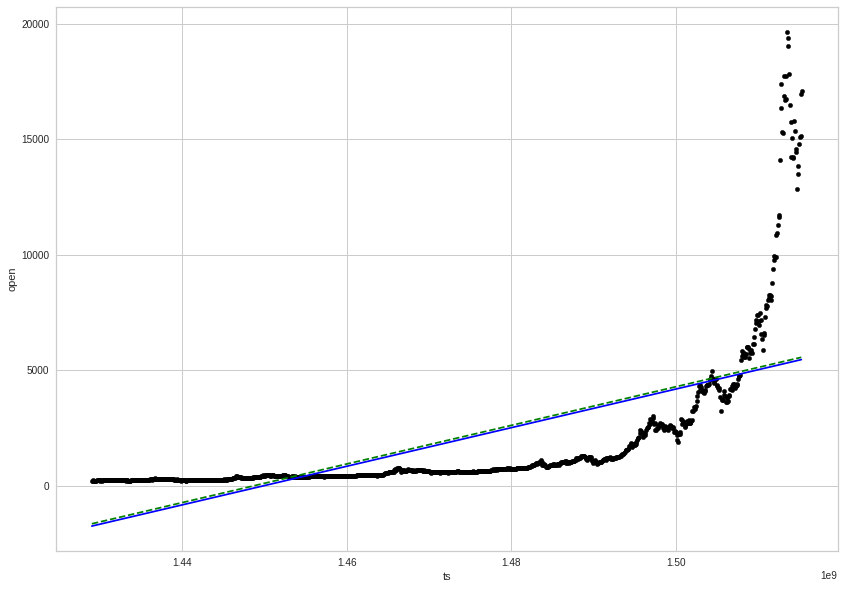

In [18]:
# Plot the real data, our prediction (blue), and the model from the coeffictient (green shifted)
ax = bit_df.plot(kind='scatter', x='ts', y='open', color='black', figsize=(14,10))
ax.plot(X, pred, color='blue')  # matplotlib plot
ax.plot(X, X*lr_model.coef_ + lr_model.intercept_+ 100, linestyle='--', color='green')

In [19]:
# Vertical distance between line and point is the error. *Ordinary Least Squares* 
# regression tries to minimize the square of the distance.
mean_squared_error(y, pred)

5905906.764562201

In [20]:
# R2 score is a measure from 0-1
# 0 - the model explains none of the variation, poor model
# 1 - 100% of the variation is explained by the model
print(r2_score(y, pred))
# Not that the .score method gives the same value
print(lr_model.score(X, y))

0.42352430530848306
0.42352430530848306


## Exercise: Regression

* Use linear regression to predict ``area`` from the other columns. (If you have ``object`` data columns, you can create *dummy columns* using ``pd.get_dummies``, ``pd.concat``, and ``pd.drop``)
* What is your score?

In [22]:
df_ff.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [25]:
y_ff = df_ff.area

In [31]:
# convert months/days into numerical
X_ff = (
    pd
    .concat([
        df_ff, 
        pd.get_dummies(df_ff.month), 
        pd.get_dummies(df_ff.day)], 
        axis=1)
    .drop(['month', 'day', 'area'], axis=1)
)
X_ff.T

,0,1,2,3,4,5,6,7,8,9,...,507,508,509,510,511,512,513,514,515,516
X,7.0,7.0,7.0,8.0,8.0,8.0,8.0,8.0,8.0,7.0,...,2.0,1.0,5.0,6.0,8.0,4.0,2.0,7.0,1.0,6.0
Y,5.0,4.0,4.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,...,4.0,2.0,4.0,5.0,6.0,3.0,4.0,4.0,4.0,3.0
FFMC,86.2,90.6,90.6,91.7,89.3,92.3,92.3,91.5,91.0,92.5,...,91.0,91.0,91.0,91.0,81.6,81.6,81.6,81.6,94.4,79.5
DMC,26.2,35.4,43.7,33.3,51.3,85.3,88.9,145.4,129.5,88.0,...,166.9,166.9,166.9,166.9,56.7,56.7,56.7,56.7,146.0,3.0
DC,94.3,669.1,686.9,77.5,102.2,488.0,495.6,608.2,692.6,698.6,...,752.6,752.6,752.6,752.6,665.6,665.6,665.6,665.6,614.7,106.7
ISI,5.1,6.7,6.7,9.0,9.6,14.7,8.5,10.7,7.0,7.1,...,7.1,7.1,7.1,7.1,1.9,1.9,1.9,1.9,11.3,1.1
temp,8.2,18.0,14.6,8.3,11.4,22.2,24.1,8.0,13.1,22.8,...,25.9,25.9,21.1,18.2,27.8,27.8,21.9,21.2,25.6,11.8
RH,51.0,33.0,33.0,97.0,99.0,29.0,27.0,86.0,63.0,40.0,...,41.0,41.0,71.0,62.0,35.0,32.0,71.0,70.0,42.0,31.0
wind,6.7,0.9,1.3,4.0,1.8,5.4,3.1,2.2,5.4,4.0,...,3.6,3.6,7.6,5.4,2.7,2.7,5.8,6.7,4.0,4.5
rain,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
lr_model.fit(X_ff, y_ff) # train model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
pred = lr_model.predict(X_ff)

In [34]:
lr_model.score(X_ff, y_ff) # poor model

0.04578209650808529

### Bonus - Visualize the errors
You can plot the actuals and the predicted values. It looks like our model does a pretty poor job

In [ ]:
# Prediction error plot from Yellowbrick
# plot of actual (blue) vs predicted (black dash)
# ideally would be around 45 degree line
fig, ax = plt.subplots(figsize=(10, 8))
err_viz = PredictionError(lr_model)
# Model is already fit
#err_viz.fit(X, y)
err_viz.score(X, y)
err_viz.poof()

In [ ]:
# plot result
y_df = pd.DataFrame(y)
y_df['pred'] = pred
y_df['err'] = y_df.pred - y_df.close
(y_df
 #.iloc[-50:]
 .plot(figsize=(14,10))
)

## Bonus Exercise: Visualize the errors
Plot y and predicted y

## Try More Features
In an attempt to get a better model we are going to use more features to make a prediction

In [35]:
# drop last row because we don't know what future is

X = (bit_df
         .drop(['close'], axis=1)
         .iloc[:-1])
y = bit_df.close.shift(-1).iloc[:-1]
cols = X.columns

In [36]:
# The describe method on a dataframe gives a statistical summary of the columns
X.describe()

,open,hi,lo,vol_btc,vol_cur,wp,ts
count,998.000000,998.000000,998.000000,998.000000,9.980000e+02,998.000000,9.980000e+02
mean,1822.818677,1899.475180,1743.835902,10348.164860,3.537227e+07,1827.510400,1.472126e+09
std,3133.803682,3313.250231,2934.620209,9952.419039,1.096674e+08,3132.853391,2.490412e+07
min,211.160000,224.040000,0.060000,1525.187302,7.925465e+05,215.969046,1.429056e+09
25%,384.527500,392.750000,371.235000,5318.074102,2.297677e+06,384.182499,1.450591e+09
50%,628.990000,638.870000,617.840000,7365.384844,3.480134e+06,632.345289,1.472126e+09
75%,1423.512500,1486.370000,1412.627500,11885.163969,1.957041e+07,1452.074386,1.493662e+09
max,19650.020000,19891.990000,19010.000000,165763.024424,1.393385e+09,19537.276941,1.515197e+09


In [37]:
# We are going to scale the data so that volume and ts don't get more
# weight that other values
ss = preprocessing.StandardScaler()
ss.fit(X)
X = ss.transform(X) # returns np array
X = pd.DataFrame(X, columns=cols) # convert to dataframe

In [38]:
# We can now see that the data has a mean close to 0
# and a std of 1
X.describe() # removes scale, but preserves variance in data

,open,hi,lo,vol_btc,vol_cur,wp,ts
count,9.980000e+02,998.000000,9.980000e+02,9.980000e+02,998.000000,9.980000e+02,9.980000e+02
mean,-5.695733e-17,0.000000,-5.695733e-17,9.967533e-17,0.000000,-5.695733e-17,-5.695733e-17
std,1.000501e+00,1.000501,1.000501e+00,1.000501e+00,1.000501,1.000501e+00,1.000501e+00
min,-5.145398e-01,-0.505931,-5.945063e-01,-8.869604e-01,-0.315473,-5.146584e-01,-1.730316e+00
25%,-4.591903e-01,-0.454985,-4.679614e-01,-5.056673e-01,-0.301741,-4.609381e-01,-8.651581e-01
50%,-3.811430e-01,-0.380665,-3.838863e-01,-2.998543e-01,-0.290954,-3.816854e-01,0.000000e+00
75%,-1.274829e-01,-0.124745,-1.129190e-01,1.545122e-01,-0.144161,-1.198984e-01,8.651581e-01
max,5.691531e+00,5.433195,5.886561e+00,1.562362e+01,12.389219,5.655753e+00,1.730316e+00


In [39]:
lr_model2 = linear_model.LinearRegression()
lr_model2.fit(X, y)
pred = lr_model2.predict(X)
lr_model2.score(X, y) # 99% of variance explained by model - mush better model

0.99315208629409

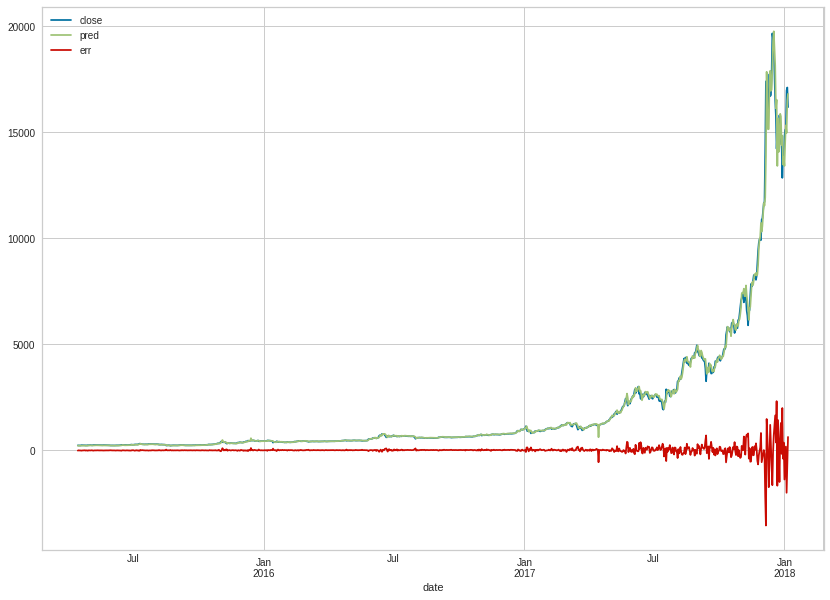

In [40]:
# plot result
y_df = pd.DataFrame(y)
y_df['pred'] = pred
y_df['err'] = y_df.pred - y_df.close
y_df.plot(figsize=(14,10))

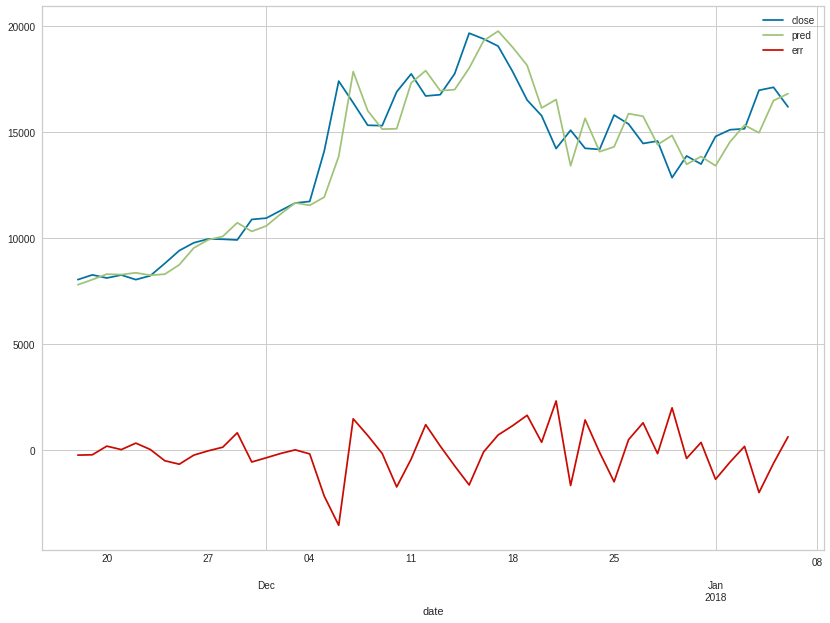

In [41]:
# plot result
y_df = pd.DataFrame(y)
y_df['pred'] = pred
y_df['err'] = y_df.pred - y_df.close
y_df.iloc[-50:].plot(figsize=(14,10))

In [42]:
# our scores get worse with recent data
lr_model2.score(X[-50:], y[-50:])

0.8945969866884239

In [43]:
lr_model2.coef_

array([-1167.23492404,  1455.22180076,  1485.18244337,     4.81798323,
          73.9503874 ,  1345.13824172,    11.66531061])

In [44]:
list(zip(X.columns, lr_model2.coef_))

[('open', -1167.234924037651),
 ('hi', 1455.2218007588954),
 ('lo', 1485.1824433677223),
 ('vol_btc', 4.81798323121609),
 ('vol_cur', 73.9503873970051),
 ('wp', 1345.1382417241107),
 ('ts', 11.665310611454743)]

In [45]:
# These coefficients correspond to the columns in X
pd.DataFrame(list(zip(X.columns, lr_model2.coef_)), columns=['Feature', 'Coeff'])

,Feature,Coeff
0,open,-1167.234924
1,hi,1455.221801
2,lo,1485.182443
3,vol_btc,4.817983
4,vol_cur,73.950387
5,wp,1345.138242
6,ts,11.665311


In [46]:
X.corr()

,open,hi,lo,vol_btc,vol_cur,wp,ts
open,1.000000,0.997546,0.996504,0.531666,0.839701,0.998789,0.650424
hi,0.997546,1.000000,0.995965,0.545547,0.855649,0.998972,0.646366
lo,0.996504,0.995965,1.000000,0.508744,0.810743,0.998509,0.658435
vol_btc,0.531666,0.545547,0.508744,1.000000,0.689945,0.530186,0.347324
vol_cur,0.839701,0.855649,0.810743,0.689945,1.000000,0.836722,0.444227
wp,0.998789,0.998972,0.998509,0.530186,0.836722,1.000000,0.652363
ts,0.650424,0.646366,0.658435,0.347324,0.444227,0.652363,1.000000


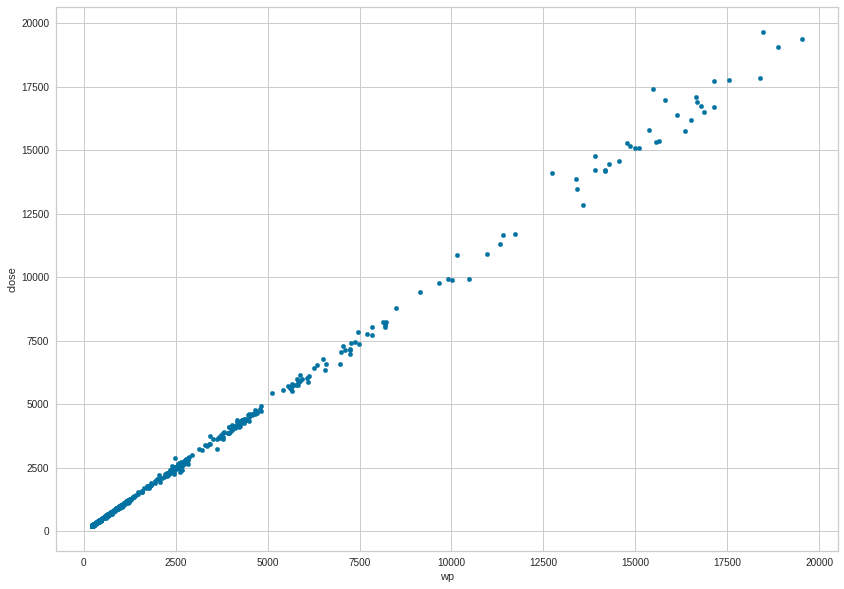

In [47]:
bit_df.plot(kind='scatter', x='wp', y='close', figsize=(14,10))

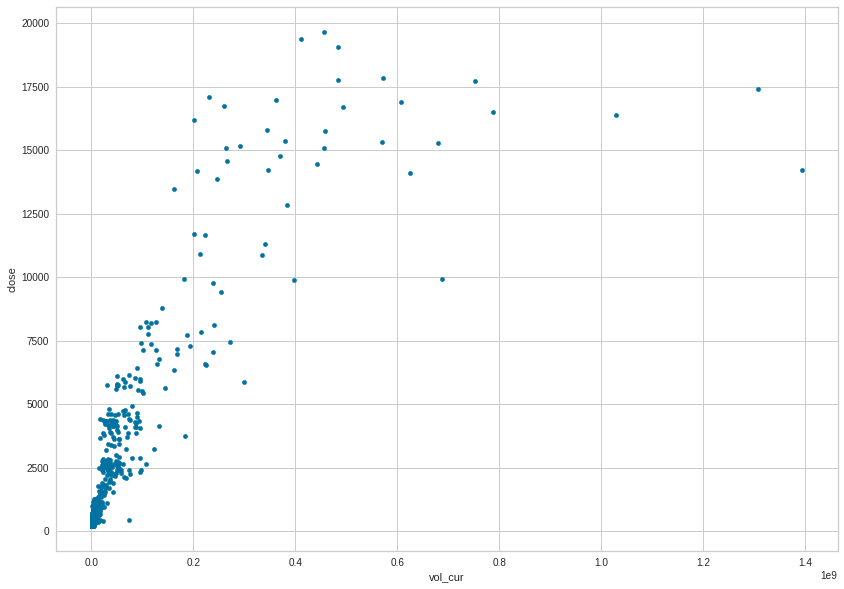

In [48]:
bit_df.plot(kind='scatter', x='vol_cur', y='close', figsize=(14,10))

## Exercise: Regression
* Try scaling the input and using the log of the area and see if you get a better score.

* Examine the coefficients



In [50]:
ss_ff = preprocessing.StandardScaler()
ss_ff.fit(X_ff)
X_ff_scaled = ss_ff.transform(X_ff)
X_ff_scaled = pd.DataFrame(X_ff_scaled, columns=X_ff.columns)
y_ff_scaled = log(ff.area)

NameError: name 'log' is not defined

## Training/Test Split
In fact we were cheating, predicting things that we already saw serves little purpose. The model could just memorize the data and get a perfect score. But it wouldn't *generalize* to unseen data.

To see how it will perform in the real world we will train on a portion of the data and test on a portion that it hasn't seen. 

In [ ]:
X_train, X_test, y_train, y_test = model_selection.\
    train_test_split(X, y, test_size=.3, random_state=42)

In [ ]:
lr_model2 = linear_model.LinearRegression()
lr_model2.fit(X_train, y_train)
lr_model2.score(X_test, y_test)

In [ ]:
y_df2 = pd.DataFrame(y_test)
y_df2['pred'] = lr_model2.predict(X_test)
y_df2['err'] = y_df2.pred - y_df2.close
(
y_df2
 #   .iloc[-50:]
    .plot(figsize=(14,10))
)

In [ ]:
# yellow brick version
fig, ax = plt.subplots(figsize=(10, 10))
err_viz2 = PredictionError(lr_model2)
err_viz2.score(X_test, y_test)
err_viz2.poof()

## Exercise: Regression with Train/Test Split

Split the data into test and training data. What is the score on the test data?

## Visualize Errors with Residual Plots
A residual is the difference between the prediction and the actual.
If we plot predicted value against residuals, we should get a random
distribution. If not, a different model more be better given the data.

In [ ]:
def residual_plot(model, X_train, y_train, X_test, y_test):
    fig = plt.figure(figsize=(14,10))
    ax = plt.subplot(111)
    plt.scatter(model.predict(X_train), 
                model.predict(X_train) - y_train, 
                c='b', alpha=.3,
                label='train')
    plt.scatter(model.predict(X_test), 
                model.predict(X_test) - y_test, 
                color='green', alpha=.3,
                label='test')
    plt.title('Residual Plot - Train (blue), Test (green)')
    plt.ylabel('Residual')
    ax.legend()
    


In [ ]:
residual_plot(lr_model2, X_train, y_train, X_test, y_test)

In [ ]:
# Yellowbrick version
fig, ax = plt.subplots(figsize=(10, 10))
res_viz = ResidualsPlot(lr_model2)
res_viz.fit(X_train, y_train)
res_viz.score(X_test, y_test)
res_viz.poof()

## Exercise - Residual Plot
Make a residual plot of your test and train data

## SVM, Random Forest, & Huber  - Other models

In [ ]:
# drop last row because we don't know what future is

X = (bit_df
         .drop(['close'], axis=1)
         .iloc[:-1])
y = bit_df.close.shift(-1).iloc[:-1]
cols = X.columns

ss = preprocessing.StandardScaler()
ss.fit(X)
X = ss.transform(X)
X = pd.DataFrame(X, columns=cols)

X_train, X_test, y_train, y_test = model_selection.\
    train_test_split(X, y, test_size=.3, random_state=42)
    
svm_model = svm.SVR(kernel='linear')
svm_model.fit(X_train, y_train)
svm_model.score(X_test, y_test)    

In [ ]:
def train_reg_model(model, df):
    # drop last row because we don't know what future is

    X = (df
             .drop(['close'], axis=1)
             .iloc[:-1])
    y = df.close.shift(-1).iloc[:-1]
    cols = X.columns

    ss = preprocessing.StandardScaler()
    ss.fit(X)
    X = ss.transform(X)
    X = pd.DataFrame(X, columns=cols)

    X_train, X_test, y_train, y_test = model_selection.\
        train_test_split(X, y, test_size=.3, random_state=42)

    #svm_model = svm.SVR(kernel='linear')
    model.fit(X_train, y_train)
    return model.score(X_test, y_test), X_test, y_test, X_train, y_train    
    
rf_reg = ensemble.RandomForestRegressor() 
score, X_test, y_test, X_train, y_train = train_reg_model(rf_reg, bit_df)
print(score)    

In [ ]:
def error_plot(X_test, y_test, model):
    y_df3 = pd.DataFrame(y_test)
    y_df3['pred'] = model.predict(X_test)
    y_df3['err'] = y_df3.pred - y_df3.close
    (
    y_df3
     #   .iloc[-50:]
        .plot(figsize=(14,10))
    )
error_plot(X_test, y_test, rf_reg)

In [ ]:
# yellow brick version
fig, ax = plt.subplots(figsize=(10, 10))
err_viz3 = PredictionError(rf_reg)
err_viz3.score(X_test, y_test)
err_viz3.poof()

In [ ]:

    
residual_plot(rf_reg, X_train, y_train, X_test, y_test)

In [ ]:
huber_reg = linear_model.HuberRegressor()
huber_reg.fit(X_train, y_train)
huber_reg.score(X_test, y_test)

In [ ]:
error_plot(X_test, y_test, huber_reg)

In [ ]:
# yellow brick version
fig, ax = plt.subplots(figsize=(10, 10))
err_viz4 = PredictionError(huber_reg)
err_viz4.score(X_test, y_test)
err_viz4.poof()

In [ ]:
residual_plot(huber_reg, X_train, y_train, X_test, y_test)

In [ ]:
huber_reg

## Exercise:

Try using another model (RandomForestRegressor or SVM)